<a href="https://colab.research.google.com/github/OMEGAeNcore/FacialEmotionDetection/blob/main/FER_on_raw_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

We will install and import the required packages for this project. We are going to use pandas, numpy, tensorflow and opencv related packages for data processing and creating our CNN model.

In [ ]:
!pip install scikit-plot

In [ ]:
# Importing required modules

# Pre-processing
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as im
from PIL import ImageEnhance, ImageFilter

# Pre-processing for prediction images
import cv2
from google.colab.patches import cv2_imshow

# Data spliting
from sklearn.model_selection import train_test_split

# Model related
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, \
Dense, Dropout, BatchNormalization, \
Activation, Flatten, Input, ZeroPadding2D, Add, AveragePooling2D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, \
TensorBoard, ModelCheckpoint

from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform

# For ploting Confusion Matrix and displaying image
import scikitplot
from sklearn.metrics import classification_report

# Loading model saved earlier
from tensorflow.keras.models import model_from_json

# Lethal's import
import skimage as si
from skimage import filters

## Dataset and Features

We are going to use FER2013 dataset provided by [Kaggle website](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data), which consists of about 37,000 well structured 48 × 48 pixel gray-scale images of faces. The images are processed in such a way that the faces
are almost centered and each face occupies about the
same amount of space in each image. Each image has
to be categorized into one of the seven classes that
express different facial emotions. These facial emotions have been categorized as: 0=Angry, 1=Disgust,
2=Fear, 3=Happy, 4=Sad, 5=Surprise, and 6=Neutral.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH = '/content/drive'

# Path to project folder on Google drive
PROJECT_PATH = '/MyDrive/FINAL YEAR PROJECT'

# Read data from csv file
df = pd.read_csv(DRIVE_PATH + PROJECT_PATH +'/input/fer2013.csv')

# Analyzing some initial data properties
print(df.shape)
df.tail()

Mounted at /content/drive
(35887, 3)


,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [ ]:
df.drop(columns='Usage', inplace=True)
df.tail()

,emotion,pixels
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...


In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
# Initializing global variables
num_features = 64
num_labels = 7
batch_size = 128
epochs = 100
width, height = 48, 48

In [ ]:
# def augment(data, num_augs = 4):
#   images = []
#   labels = []
#   for id, row in data.iterrows():
#     face = [int(pixel) for pixel in row.pixels.split(' ')]
#     face = np.asarray(face).reshape(width, height).astype('float32')
#     face = np.expand_dims(face, axis = -1)

#     for i in range(num_augs):
#       im = face
#       #rotate
#       if(np.random.uniform() < 0.3):
#         angle = np.random.uniform(-1, 1) * 90
#         im = si.transform.rotate(im, angle)

#       #flip 
#       if(np.random.uniform() < 0.3):
#         im = im[::-1,:,:]        
#       if(np.random.uniform() < 0.3):
#         im = im[:,::-1,:]

#       #blur
#       if(np.random.uniform() < 0.8):
#         im = filters.gaussian(im, sigma = np.random.uniform(0,1.5)) 

#       #noise
#       if(np.random.uniform() < 0.3):
#         noise = np.random.binomial(n=2, p = np.random.uniform(0.3, 0.9), size = im.shape)
#         im = np.multiply(im, noise)

#       images.append(im)
#       labels.append(np.identity(7)[row.emotion])

#   return np.array(images), np.array(labels)

In [ ]:
# def sample(data, sample_size = 128, num_augs = 4, class_column = 'emotion', steps_per_epoch = 10, epoch = 100):    
#   sample_size = int(sample_size/num_augs)
#   class_freq = data.groupby(class_column).size()
#   class_weights = 1/class_freq
#   weight_column = class_weights[data[class_column]]
#   weight_column = weight_column.reset_index(drop = True)
#   data['weights'] = weight_column
  
#   for iter in range(steps_per_epoch * epoch):
#     _sample = data.sample(sample_size, weights = 'weights')  
#     yield augment(_sample, num_augs = num_augs)

In [ ]:
df = df.sample(frac=1)
df.head()

,emotion,pixels
3743,3,78 81 82 82 80 77 75 74 78 57 39 36 36 42 51 7...
23064,3,34 33 28 25 25 26 26 25 26 27 28 37 51 70 94 1...
24010,2,255 255 255 255 255 253 254 109 14 22 13 7 6 5...
20043,3,194 206 208 208 210 211 213 213 214 216 215 21...
9215,6,66 61 54 59 71 61 60 49 34 52 86 69 61 85 112 ...


In [ ]:
# df_1 = df.sample(frac=0.9)
# df_2 = df.drop(df_1.index)
# print(df_1.shape)
# print(df_2.shape)

### Data processing and augmentation

In addition to the image class number (a
number between 0 and 6), the given images are divided
into three different sets which are training, validation,
and test sets. We split the data using *train_test_split()* function for spliting into training, validation and testing dataset. We have our image data in pixel array format, which is a string. We convert the string of pixels into  **float32** numpy arrays.

In [ ]:
data_from_df_dictmode = {}

def dictionary_data():
    for index, row in df.iterrows():
        face = [int(pixel) for pixel in row.pixels.split(' ')]
        face = np.asarray(face).reshape(width, height).astype('float32')
        row.pixels = face
        data_from_df_dictmode[index] = row

dictionary_data()
data_from_df = pd.DataFrame.from_dict(data_from_df_dictmode, orient='index')
data_from_df.tail()

,emotion,pixels
35882,6,"[[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39..."
35883,3,"[[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19..."
35884,0,"[[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17..."
35885,3,"[[30.0, 28.0, 28.0, 29.0, 31.0, 30.0, 42.0, 68..."
35886,2,"[[19.0, 13.0, 14.0, 12.0, 13.0, 16.0, 21.0, 33..."


In [ ]:
# import random
# def data_augment_func(pixel):
#     augment = []
#     augment_ch = range(1,6)
    
#     data = im.fromarray(pixel).convert('L')
#     flip_top_down = data.transpose(method=im.FLIP_TOP_BOTTOM)
#     flip_left_right = data.transpose(method=im.FLIP_LEFT_RIGHT)

#     augment.append(data)
#     augment.append(flip_top_down)
#     augment.append(flip_left_right)

#     elemental = []
#     for i in range(3):
#         ch = random.choices(augment_ch, k=3)
#         for c in ch:
#             if c == 1:
#                 elemental.append(augment[i].rotate(random.choice(range(1,359))))
#             elif c == 2:
#                 elemental.append(ImageEnhance.Sharpness(augment[i]).enhance(5))
#             elif c == 3:
#                 elemental.append(augment[i].filter(ImageFilter.GaussianBlur(1.5)))
#             elif c == 4:
#                 elemental.append(ImageEnhance.Brightness(augment[i]).enhance(2))
#             elif c == 5:
#                 elemental.append(ImageEnhance.Contrast(augment[i]).enhance(3))
    
#     augment[1] = np.array(augment[1])
#     augment[2] = np.array(augment[2])

#     for i in range(len(elemental)):
#         augment.append(np.array(elemental[i]))

#     del augment[0]
#     return augment

In [ ]:
# """
#     Create a function to augment data of type 'disgust'
#     == Convert to image
#     == perform shift, noise, blur, flips, rotate
#     == check and convert to np array
#     == append to the branch array with same label; along with the original image array
# """
# modified_key1_data = {}
# counter = 35887
# def get_image_for_augmentation():
#     global counter
#     for key, row in data_from_df.iterrows():
#         pixel_da = []
#         if row.emotion == 1:
#             # Return augmented data in some format
#             pixel_da = data_augment_func(row.pixels)

#             # Iterate through the augmented data which will be added later to the main dataframe [ keeping shape and size similar to original image data ]
#             for op in pixel_da:
#                 test = {}
#                 test['emotion'] = 1
#                 test['pixels'] = op
#                 # Append it as a key value pair
#                 modified_key1_data[counter] = test
#                 counter += 1

# get_image_for_augmentation()
# md = pd.DataFrame.from_dict(modified_key1_data, orient='index')
# md

In [ ]:
# for index, row in md.iterrows():
#     if index == 36000:
#         break
#     cv2_imshow(row.pixels)

In [ ]:
# # Append modified_key1_data to main data
# tst_df = data_from_df.append(md, ignore_index=True)
# print(tst_df.tail())
# # Shuffle data according to index of the modified dataframe
# tst_df = tst_df.sample(frac=1)
# print(tst_df.tail())

# tst_df.shape

In [ ]:
# pixels_ar = tst_df['pixels'].tolist()
pixels_ar = data_from_df['pixels'].tolist()
faces = np.asarray(pixels_ar)
faces = np.expand_dims(faces, axis=-1)

In [ ]:
# Saving emotions of the images as a matrix, i.e. each image has a row of 
# different emotions, but only the marked(1) emotion is represented by the image
# emotions = pd.get_dummies(tst_df['emotion']).values
emotions = pd.get_dummies(data_from_df['emotion']).values

In [ ]:
x = faces.copy()
y = emotions.copy()

In [ ]:
# Splitting into training and test dataset (shuffle to randomize)
X_train, X_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.1, 
    random_state=42
    )


X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=0.1, 
    random_state=41
    )

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(29068, 48, 48, 1) (29068, 7)
(3589, 48, 48, 1) (3589, 7)
(3230, 48, 48, 1) (3230, 7)


## Experiments

We have created a model using 4 Convolutional layers and 2 Fully Connected layers.

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1), kernel_initializer=glorot_uniform))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25))
# model.add(Dropout(0.4))

model.add(Conv2D(128, (5,5), padding='same', kernel_initializer=glorot_uniform))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
# model.add(Dropout(0.4))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding='same', kernel_initializer=glorot_uniform))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding='same', kernel_initializer=glorot_uniform))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='linear', kernel_initializer=glorot_uniform))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.4))
model.add(Dropout(0.25))

model.add(Dense(512, activation='linear', kernel_initializer=glorot_uniform))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax', kernel_initializer=glorot_uniform))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=0.00001, min_delta=0.0001, model='auto', verbose=1)
es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
mc = ModelCheckpoint(DRIVE_PATH+PROJECT_PATH+'/data_from_notebook/model_F.h5', monitor='val_accuracy', verbose=1, mode='max' , save_best_only=True)

In [ ]:
# H = model.fit_generator(sample(df_1, epoch=1500),
#                         steps_per_epoch=10,
#                         epochs=1500,
#                         verbose=1,
#                         validation_data=sample(df_2, epoch=1500),
#                         validation_steps=5,
#                         shuffle=True,
#                         callbacks=[mc])

In [ ]:
H = model.fit(np.array(X_train), np.array(y_train),
              batch_size=batch_size,
              validation_data=(np.array(X_valid), np.array(y_valid)),
              epochs=80,
              verbose=1,
              shuffle=True,
              callbacks=[mc,lrr,es])

Epoch 1/80
228/228 [==============================] - 53s 97ms/step - loss: 1.8351 - accuracy: 0.2966 - val_loss: 1.7667 - val_accuracy: 0.3542

Epoch 00001: val_accuracy improved from -inf to 0.35418, saving model to /content/drive/MyDrive/FINAL YEAR PROJECT/data_from_notebook/model_F.h5
Epoch 2/80
228/228 [==============================] - 21s 93ms/step - loss: 1.5496 - accuracy: 0.4055 - val_loss: 1.5985 - val_accuracy: 0.4034

Epoch 00002: val_accuracy improved from 0.35418 to 0.40341, saving model to /content/drive/MyDrive/FINAL YEAR PROJECT/data_from_notebook/model_F.h5
Epoch 3/80
228/228 [==============================] - 21s 93ms/step - loss: 1.3814 - accuracy: 0.4730 - val_loss: 1.3551 - val_accuracy: 0.4830

Epoch 00003: val_accuracy improved from 0.40341 to 0.48297, saving model to /content/drive/MyDrive/FINAL YEAR PROJECT/data_from_notebook/model_F.h5
Epoch 4/80
228/228 [==============================] - 21s 93ms/step - loss: 1.2824 - accuracy: 0.5069 - val_loss: 1.2015 - v

### Holdout Method for validation
We check the accuracy of our current model, using the test set, which was kept separate from the training and validation set, that is, the model is unaware of the data present in the test set.

In [ ]:
# Holdout Validation using unseen data, ie, test dataset
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=64)

print("Holdout Method of Validation Scores:")
print("Loss: {:.4f}".format(scores[0]))
print("Accuracy: {:.2f}%".format(scores[1] * 100))

# Saving the  model to be used later
fer_json = model.to_json()
with open(DRIVE_PATH+PROJECT_PATH+'/data_from_notebook/fer_F.json', "w") as json_file:
    json_file.write(fer_json)
model.save_weights(DRIVE_PATH+PROJECT_PATH+"/data_from_notebook/model_weights_F.h5")
print("Saved model to disk")

57/57 [==============================] - 1s 21ms/step - loss: 1.1893 - accuracy: 0.6576
Holdout Method of Validation Scores:
Loss: 1.1893
Accuracy: 65.76%
Saved model to disk


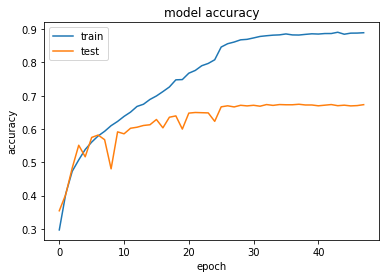

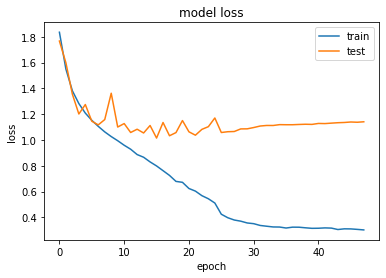

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

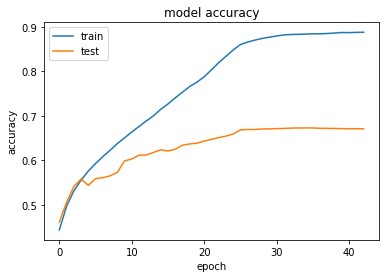

In [ ]:
h_acc = H.history['accuracy']
h_val_acc = H.history['val_accuracy']
frame = 5
av_acc = [np.mean(h_acc[x:x+frame]) for x in range(len(h_acc) - frame)]
av_val_acc = [np.mean(h_val_acc[x:x+frame]) for x in range(len(h_val_acc) - frame)]
plt.plot(av_acc)
plt.plot(av_val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.title('model accuracy')
plt.show()

### Confusion matrix
We display the confusion matrix of size N x N, for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. 


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


total wrong validation predictions: 1229


              precision    recall  f1-score   support

           0       0.58      0.55      0.56       498
           1       0.74      0.56      0.64        52
           2       0.60      0.47      0.53       545
           3       0.83      0.86      0.84       881
           4       0.50      0.57      0.53       588
           5       0.79      0.76      0.77       414
           6       0.59      0.65      0.62       611

    accuracy                           0.66      3589
   macro avg       0.66      0.63      0.64      3589
weighted avg       0.66      0.66      0.66      3589



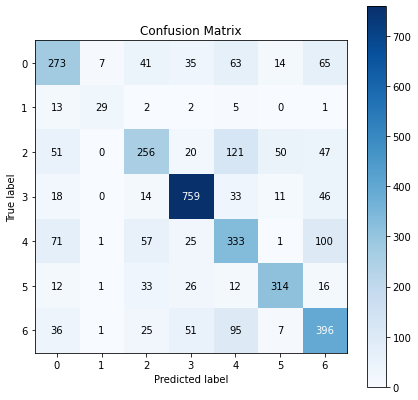

In [ ]:
yhat_valid = model.predict_classes(X_test)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_valid, figsize=(7,7))
plt.savefig(DRIVE_PATH+PROJECT_PATH+"/data_from_notebook/confusion_matrix_F.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))

### Overall Accuracy and Class-wise accuracy
This confusion matrix gives us a holistic view of how well our classification model is performing and what kinds of errors it is making. We also display the number of wrong validation predictions.

\begin{array}{rcl} \text{Accuracy} & = & \dfrac{\text{Number of correct predictions}}{\text{Total number of predictions}} \\ \end{array}

We will find the total number of correct predictions over the diagonal of the confusion matrix and the total number of predictions by adding the summation of the number of predictions over each column.
Here, we display the percentage accuracy of each class, predicted by our model, based on the test set.

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test, axis=1), yhat_valid)
print("Overall accuracy: {:.2f}%".format(100*sum(cm.diagonal())/y_test.shape[0]))

cm = (cm.astype('float') / cm.sum(axis=1))
class_wise = cm.diagonal() * 100

np.set_printoptions(precision=3)
print("\nConfusion matrix [TP. / Total number of data of that class]:\n",np.array(cm),"\n")

np.set_printoptions(precision=2)
print("Class-wise accuracy: {}".format(np.array(class_wise)))

Overall accuracy: 65.76%

Confusion matrix [TP. / Total number of data of that class]:
 [[0.548 0.135 0.075 0.04  0.107 0.034 0.106]
 [0.026 0.558 0.004 0.002 0.009 0.    0.002]
 [0.102 0.    0.47  0.023 0.206 0.121 0.077]
 [0.036 0.    0.026 0.862 0.056 0.027 0.075]
 [0.143 0.019 0.105 0.028 0.566 0.002 0.164]
 [0.024 0.019 0.061 0.03  0.02  0.758 0.026]
 [0.072 0.019 0.046 0.058 0.162 0.017 0.648]] 

Class-wise accuracy: [54.82 55.77 46.97 86.15 56.63 75.85 64.81]


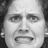

In [ ]:
# Load image
input_image_from_user_path = DRIVE_PATH + PROJECT_PATH + '/input/CK_dataset/fear/S999_003_00000055.png'
cap = cv2.imread(input_image_from_user_path, 0)
cv2_imshow(cap)

In [ ]:
np.asarray(cap).shape

(48, 48)

In [ ]:
face_cascade = cv2.CascadeClassifier(DRIVE_PATH + PROJECT_PATH + '/input/haarcascade_frontalface_alt.xml') 

In [ ]:
face_coords = face_cascade.detectMultiScale(cap, scaleFactor=1.1, minNeighbors=3)

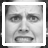

In [ ]:
# fc_w, fc_h = face_coords[1][2], face_coords[1][3]
for x, y, w, h in face_coords:
    # if w == fc_w and h == fc_h:
    cv2.rectangle(cap, (x,y), (x+w, y+h), (255, 0,0), thickness=2)

cv2_imshow(cap)

In [ ]:
face_coords

array([[ 3,  3, 41, 41]], dtype=int32)

In [ ]:
def image_croping(image, cropBox, boxScale=1):
    # Crop a PIL image with the provided box [x(left), y(upper), w(width), h(height)]

    # Calculate scale factors
    xDelta=max(cropBox[2]*(boxScale-1),0)
    yDelta=max(cropBox[3]*(boxScale-1),0)

    # Convert cv box to PIL box [left, upper, right, lower]
    PIL_box=[cropBox[0]-xDelta, cropBox[1]-yDelta, cropBox[0]+cropBox[2]+xDelta, cropBox[1]+cropBox[3]+yDelta]

    # return type(image)
    return image.crop(PIL_box)

cropped_img = image_croping(im.fromarray(cap), face_coords[0])

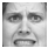

In [ ]:
cv2_imshow(cv2.resize(np.asarray(cropped_img.convert('L')), (48, 48)))

In [ ]:
output_img = cv2.resize(np.asarray(cropped_img), (48, 48)).reshape(1, 48, 48, 1)
# cv2_imshow(output_img)
output_img.shape

(1, 48, 48, 1)

In [ ]:
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

In [ ]:
model_predict = model.predict(output_img)
model_predict = [model_predict[0][i] * 100 for i in range(len(model_predict[0]))]
prediction_class = np.argmax(model_predict)
print(model_predict, emotion_dict[prediction_class])

[1.0142973624169827, 0.07151853060349822, 86.44357323646545, 0.0030772880563745275, 10.904820263385773, 0.6192900240421295, 0.9434164501726627] Fear
